# Genrify Project - Phase II
## Music genre prediction

Henri Toussaint<br>
Victor Saint Guilhem<br>
Benoît Lafon<br>

The project sets out to predict the genre of a music using the Spotify API, which provides audio features for each tracks. To collect the tracks, we used a recommandation function with a genre seed. We handpicked 20 genres in order to best represent tracks, and from each genre, we collected 100 tracks.

In [1]:
from genrify_module import *
%matplotlib inline

### Data Loading Using Pandas

In [2]:
data = pd.read_csv("music_collection.csv")
#data = data.iloc[np.random.permutation(len(data))]
pd_attributes = data.loc[:,'acousticness':'valence']
attributes = np.array(pd_attributes)

### Data Shape

In [3]:
print('Number of instances: ' + str(data.shape[0]))
print('Number of attributes: ' + str(pd_attributes.shape[1]))
print('Attributes:')
for i in pd_attributes.columns.values:
    print('\t'+str(i))

Number of instances: 2000
Number of attributes: 13
Attributes:
	acousticness
	danceability
	duration_ms
	energy
	instrumentalness
	key
	liveness
	loudness
	mode
	speechiness
	tempo
	time_signature
	valence


### Performance Measure

# We chose the accuraccy measure because blablabla (à remplir)

In [4]:
#To store the performance of different models
global_accuracy_scores = {}

### Scaling

In [5]:
sc_attributes = scale(attributes)

### Multinomial Target Variable

In [6]:
GENRES = ['alternative','blues','classical','country','electro','folk','french','hard-rock','heavy-metal','hip-hop','indie','jazz','pop','psych-rock','punk-rock','r-n-b','reggae','rock','soul','techno']
target_multinomial = []
for i in data['genre']:
    target_multinomial.append(GENRES.index(i))
target_multinomial=np.array(target_multinomial)

## Baselines

### Random prediction

In [7]:
random_model = DummyClassifier(strategy='uniform')

random_acc_scores = cross_val_score(random_model, sc_attributes, target_multinomial,cv=10)
avg_random_acc = np.mean(random_acc_scores)
print("Averaged Accuracy: " + str(avg_random_acc))
global_accuracy_scores["Random"] = avg_random_acc

Averaged Accuracy: 0.0565


### Predicting the majority class

In [8]:
majo_model = DummyClassifier(strategy='most_frequent')

majo_acc_scores = cross_val_score(majo_model, sc_attributes, target_multinomial,cv=10)
avg_majo_acc = np.mean(majo_acc_scores)
print("Averaged Accuracy: " + str(avg_majo_acc))
global_accuracy_scores["Majority Class "] = avg_majo_acc

Averaged Accuracy: 0.05


## Model selection

### Logistic Regression

In [9]:
Cs = [0.01, 0.1]
Cs.extend(range(10, 310, 10))
max_score = 0
best_c = Cs[0]

for c in Cs:
    model = LogisticRegression(C=c, multi_class='multinomial', solver='newton-cg', random_state=1)
    score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10, scoring='accuracy'))
    print("Averaged accuracy for c=" + str(c) + ": " + str(score) )
    if (score > max_score):
        max_score = score
        best_c = c

print("Best accuracy is "+ str(max_score) + " with c=" + str(best_c))
global_accuracy_scores["Logistic Regression "] = max_score


Averaged accuracy for c=0.01: 0.335
Averaged accuracy for c=0.1: 0.359
Averaged accuracy for c=10: 0.365
Averaged accuracy for c=20: 0.3675
Averaged accuracy for c=30: 0.3685
Averaged accuracy for c=40: 0.37
Averaged accuracy for c=50: 0.37
Averaged accuracy for c=60: 0.37
Averaged accuracy for c=70: 0.37
Averaged accuracy for c=80: 0.3705
Averaged accuracy for c=90: 0.3705
Averaged accuracy for c=100: 0.3705
Averaged accuracy for c=110: 0.3705
Averaged accuracy for c=120: 0.3705
Averaged accuracy for c=130: 0.371
Averaged accuracy for c=140: 0.371
Averaged accuracy for c=150: 0.371
Averaged accuracy for c=160: 0.37
Averaged accuracy for c=170: 0.371
Averaged accuracy for c=180: 0.3705
Averaged accuracy for c=190: 0.3705
Averaged accuracy for c=200: 0.3705
Averaged accuracy for c=210: 0.3705
Averaged accuracy for c=220: 0.3705
Averaged accuracy for c=230: 0.3705
Averaged accuracy for c=240: 0.3705
Averaged accuracy for c=250: 0.3705
Averaged accuracy for c=260: 0.3705
Averaged accuracy

### Decision Tree

For the decision tree, default parameters seems to not enhance the result much. 

Therefore, we just launched it several times to find a maximum accuracy.

In [10]:
max_score = 0
for i in range(100):
    model = tree.DecisionTreeClassifier()
    score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
#    print("Averaged accuracy: " + str(score) )
    if (score >= max_score):
        max_score = score

print("Best accuracy is "+ str(max_score))
global_accuracy_scores["Decision Tree "] = max_score

Best accuracy is 0.2475


### Naïve Bayes

In [11]:
NB_model = GaussianNB()
NB_acc_scores = cross_val_score(NB_model, sc_attributes, target_multinomial,cv=10)

avg_NB_acc = np.mean(NB_acc_scores)
print("Averaged Naïve Bayes Accuracy: " + str(avg_NB_acc))
global_accuracy_scores["Naive Bayes"] = max_score

Averaged Naïve Bayes Accuracy: 0.302


### Neural Networks

In [12]:
Alphas = [0.1, 1, 2, 5, 10, 20]
HLsizes = [20, 25, 30, 50, 100, 200]
Activation_functions = ['tanh', 'identity', 'logistic', 'relu']
default_alpha = 5
default_size = 25
final_score = 0
final_alpha = 0
final_size = 0

for f in Activation_functions:
    print("\nUsing " + f + " as activation function:")
    max_score=0
    best_alpha = default_alpha
    best_size = default_size
    
    for a in Alphas:
        model = MLPClassifier(hidden_layer_sizes=(best_size,),alpha=a,activation=f, solver='lbfgs', random_state = 1)
        score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
        print("Averaged accuracy for alpha=" + str(a) + ": " + str(score) )
        if (score >= max_score):
            max_score = score
            best_alpha = a
    
    print("Best accuracy is "+ str(max_score) + " with alpha=" + str(best_alpha))
    
    max_score = 0
    for s in HLsizes:
        model = MLPClassifier(hidden_layer_sizes=(s,), alpha=best_alpha, activation=f, solver='lbfgs', random_state = 1)
        score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
        print("Averaged accuracy for hidden layer size s=" + str(s) + ": " + str(score) )
        if (score > max_score):
            max_score = score
            best_size = s
    
    print("Best accuracy is "+ str(max_score) + " with hidden layer size s=" + str(best_size))
    if (max_score > final_score):
        final_score = max_score
        final_alpha = best_alpha
        final_size = best_size

print("\nThe best final accuracy is " + str(final_score) + " with a hidden layer size of s=" + str(final_size) + " and alpha=" + str(final_alpha)+ ".\n")
global_accuracy_scores["Neural Networks"] = final_score

Using tanh as activation function:
Averaged accuracy for alpha=0.1: 0.3035
Averaged accuracy for alpha=1: 0.326
Averaged accuracy for alpha=2: 0.338
Averaged accuracy for alpha=5: 0.3635
Averaged accuracy for alpha=10: 0.3705
Averaged accuracy for alpha=20: 0.3675
Best accuracy is 0.3705 with alpha=10
Averaged accuracy for hidden layer size s=20: 0.3675
Averaged accuracy for hidden layer size s=25: 0.3705
Averaged accuracy for hidden layer size s=30: 0.366
Averaged accuracy for hidden layer size s=50: 0.368
Averaged accuracy for hidden layer size s=100: 0.368
Averaged accuracy for hidden layer size s=200: 0.369
Best accuracy is 0.3705 with hidden layer size s=25
Using identity as activation function:
Averaged accuracy for alpha=0.1: 0.372
Averaged accuracy for alpha=1: 0.3685
Averaged accuracy for alpha=2: 0.3675
Averaged accuracy for alpha=5: 0.366
Averaged accuracy for alpha=10: 0.364
Averaged accuracy for alpha=20: 0.3655
Best accuracy is 0.372 with alpha=0.1
Averaged accuracy for h

### Support Vector Machine

In [13]:
Cs = [0.01,0.1,1,2,3,5]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    print("Using "+ k + " kernel")
    max_score = 0
    best_c = Cs[0]
    for c in Cs:
        model = SVC(kernel = k,C=c, random_state=1)
        score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10, scoring='accuracy'))
        print("Averaged accuracy for c=" + str(c) + ": " + str(score) )
        if (score > max_score):
            max_score = score
            best_c = c
            
    print("Best accuracy is "+ str(max_score) + " with c=" + str(best_c)+"\n")

global_accuracy_scores["Support Vector Machine"] = max_score

Using linear kernel
Averaged accuracy for c=0.01: 0.3245
Averaged accuracy for c=0.1: 0.3665
Averaged accuracy for c=1: 0.3655
Averaged accuracy for c=2: 0.3645
Averaged accuracy for c=3: 0.366
Averaged accuracy for c=5: 0.3645
Best accuracy is 0.3665 with c=0.1

Using poly kernel
Averaged accuracy for c=0.01: 0.1395
Averaged accuracy for c=0.1: 0.207
Averaged accuracy for c=1: 0.293
Averaged accuracy for c=2: 0.302
Averaged accuracy for c=3: 0.299
Averaged accuracy for c=5: 0.3025
Best accuracy is 0.3025 with c=5

Using rbf kernel
Averaged accuracy for c=0.01: 0.3125
Averaged accuracy for c=0.1: 0.3155
Averaged accuracy for c=1: 0.346
Averaged accuracy for c=2: 0.3445
Averaged accuracy for c=3: 0.3415
Averaged accuracy for c=5: 0.3315
Best accuracy is 0.346 with c=1

Using sigmoid kernel
Averaged accuracy for c=0.01: 0.277
Averaged accuracy for c=0.1: 0.287
Averaged accuracy for c=1: 0.2945
Averaged accuracy for c=2: 0.29
Averaged accuracy for c=3: 0.2855
Averaged accuracy for c=5: 0.

### Random Forest

According to [the documentation of scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html#parameters), the main parameters to adjust when using these methods are n_estimators and max_features.

Besides, it can be seen in the same page that empirical good default value for classification tasks is max_features=sqrt(n_features), which is the default value.

Thus, the optimization will only be done over n_estimators.

After a first loop, we saw that there is no significan enhancement after n_estimators > 50

In [20]:
estimators = range(50, 71, 1)
max_score = 0
best_estimator = 1

for e in estimators:
    model = RandomForestClassifier(n_estimators=e, random_state=1)
    score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
    print("Averaged accuracy for estimator=" + str(e) + ": " + str(score) )
    if (score >= max_score):
        max_score = score
        best_estimator = e

print("Best accuracy is "+ str(max_score) + " with estimator=" + str(best_estimator))
global_accuracy_scores["Random Forest"] = max_score

Averaged accuracy for estimator=50: 0.3545
Averaged accuracy for estimator=51: 0.356
Averaged accuracy for estimator=52: 0.3495
Averaged accuracy for estimator=53: 0.348
Averaged accuracy for estimator=54: 0.353
Averaged accuracy for estimator=55: 0.3505
Averaged accuracy for estimator=56: 0.3515
Averaged accuracy for estimator=57: 0.3495
Averaged accuracy for estimator=58: 0.352
Averaged accuracy for estimator=59: 0.3515
Averaged accuracy for estimator=60: 0.352
Averaged accuracy for estimator=61: 0.351
Averaged accuracy for estimator=62: 0.352
Averaged accuracy for estimator=63: 0.354
Averaged accuracy for estimator=64: 0.356
Averaged accuracy for estimator=65: 0.3555
Averaged accuracy for estimator=66: 0.3525
Averaged accuracy for estimator=67: 0.356
Averaged accuracy for estimator=68: 0.3595
Averaged accuracy for estimator=69: 0.359
Averaged accuracy for estimator=70: 0.361
Best accuracy is 0.361 with estimator=70


### Comparison of Models

<Container object of 8 artists>

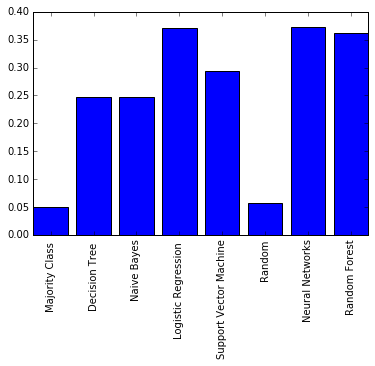

In [33]:
plt.xticks(range(len(global_accuracy_scores)), global_accuracy_scores.keys(), rotation=90)
plt.bar(range(len(global_accuracy_scores)), global_accuracy_scores.values(), align='center')

### Final Model

The model that best fits our data is Neural Network

## Important Features

In [36]:
x_train, x_test, y_train, y_test = train_test_split(sc_attributes, target_multinomial, train_size=0.67, random_state=1)

best_model =  LogisticRegression(C=lr_best_c, multi_class='multinomial', solver='newton-cg')
best_model_fitted = best_model.fit(x_train,y_train)


indices_max_weights = np.argmax(best_model_fitted.coef_, axis=1)
indices_min_weights = np.argmin(best_model_fitted.coef_, axis=1)

for index,genre in enumerate(GENRES):
    print('%s:' % genre)
    print('\tBest attribute %s - weights=%0.3f' % (pd_attributes.columns.values[indices_max_weights[index]], best_model_fitted.coef_[index][indices_max_weights[index]]))
    print('\tWorst attribute %s - weights=%0.3f' % (pd_attributes.columns.values[indices_min_weights[index]], best_model_fitted.coef_[index][indices_min_weights[index]]))

NameError: name 'lr_best_c' is not defined